In [71]:
%pylab

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


/Users/oleg/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [72]:
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

In [73]:
%matplotlib inline

In [74]:
set_printoptions(formatter={'float': '{:>11.3f}'.format})

# Загрузка данных

In [5]:
breast_cancer_data = load_breast_cancer()
breast_cancer_data, breast_cancer_target = load_breast_cancer(return_X_y=True)

# Матрицы ковариации и признаки

## Диаграмма рассеяния для двух произвольно взятых признаков

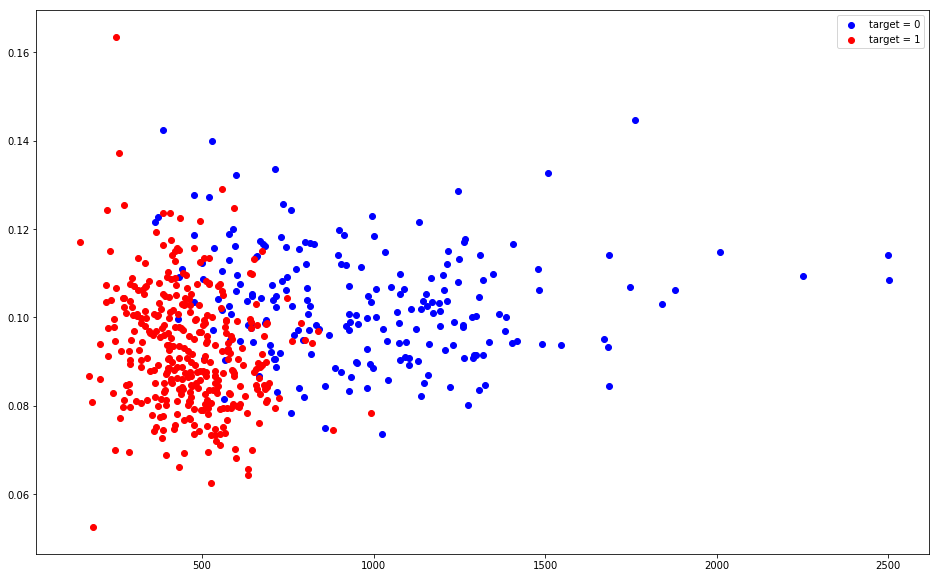

In [11]:
figsize(16, 10)
cmap = ('b', 'r')
for i in range(len(cmap)):
    scatter(breast_cancer_data[breast_cancer_target == i,3], 
            breast_cancer_data[breast_cancer_target == i,4], 
            c=cmap[i], 
            label='target = {}'.format(i))
legend()
None

## Матрица ковариации исходных данных

In [12]:
covariation_matrix = cov(breast_cancer_data.T)
print(covariation_matrix[:6, :6])

[[     12.419       4.908      85.447    1224.483       0.008       0.094]
 [      4.908      18.499      34.440     485.994      -0.001       0.054]
 [     85.447      34.440     590.440    8435.772       0.071       0.715]
 [   1224.483     485.994    8435.772  123843.554       0.876       9.265]
 [      0.008      -0.001       0.071       0.876       0.000       0.000]
 [      0.094       0.054       0.715       9.265       0.000       0.003]]


Для удобства показаны только первые 6 строк и столбцов (и в дальнейшем также)

### Расчет главных компонент

In [14]:
pca = PCA()
breast_cancer_data_pca = pca.fit_transform(breast_cancer_data)

### Матрица ковариации исходных данных, спроецированная на главные компоненты

In [15]:
covariation_matrix_pca = cov(breast_cancer_data_pca.T)
print(covariation_matrix_pca[:6, :6])

[[ 443782.605      -0.000      -0.000       0.000      -0.000      -0.000]
 [     -0.000    7310.100       0.000      -0.000       0.000      -0.000]
 [     -0.000       0.000     703.834      -0.000       0.000       0.000]
 [      0.000      -0.000      -0.000      54.649       0.000      -0.000]
 [     -0.000       0.000       0.000       0.000      39.890       0.000]
 [     -0.000      -0.000       0.000      -0.000       0.000       3.005]]


### Проверка, что главные компоненты ортогональны

In [16]:
print(matmul(pca.components_, pca.components_.T)[:6, :6])

[[      1.000       0.000      -0.000       0.000       0.000       0.000]
 [      0.000       1.000       0.000      -0.000      -0.000      -0.000]
 [     -0.000       0.000       1.000      -0.000      -0.000      -0.000]
 [      0.000      -0.000      -0.000       1.000       0.000       0.000]
 [      0.000      -0.000      -0.000       0.000       1.000       0.000]
 [      0.000      -0.000      -0.000       0.000       0.000       1.000]]


При произведении матрицы на ее транспонированный вариант получилась единичная матрица, следовательно исходная матрица была ортогональной. Т.е. все главные компоненты ортогональны

### Сравнение собственных значений матрицы ковариации исходных данных со значениями дисперсии главных компонент

#### Собственные значения матрицы ковариации исходных данных

In [17]:
eigenvalues, eigenvectors = linalg.eig(covariation_matrix)
print(eigenvalues)

[ 443782.605    7310.100     703.834      54.649      39.890       3.005
       1.815       0.371       0.156       0.084       0.032       0.007
       0.003       0.002       0.001       0.001       0.000       0.000
       0.000       0.000       0.000       0.000       0.000       0.000
       0.000       0.000       0.000       0.000       0.000       0.000]


#### Значения дисперсии главных компонент

In [18]:
print(diagonal(covariation_matrix_pca))

[ 443782.605    7310.100     703.834      54.649      39.890       3.005
       1.815       0.371       0.156       0.084       0.032       0.007
       0.003       0.002       0.001       0.001       0.000       0.000
       0.000       0.000       0.000       0.000       0.000       0.000
       0.000       0.000       0.000       0.000       0.000       0.000]


### Сравнение следов матрицы ковариации исходных данных и матрицы ковариации данных, спроецированных на главные компоненты

#### След матрицы ковариации исходных данных

In [19]:
trace(covariation_matrix)

451896.55625739868

#### След матрицы ковариации исходных данных, спроецированных на главные компоненты

In [20]:
trace(covariation_matrix_pca)

451896.55625739868

Как видно, это значение не изменяется при проецировании на главные компоненты (с точностю до погрешности вычислений)

In [21]:
total_variance = trace(covariation_matrix)

### Графики объясненной дисперсии

In [22]:
explained_variance_ratio = diagonal(covariation_matrix) / total_variance

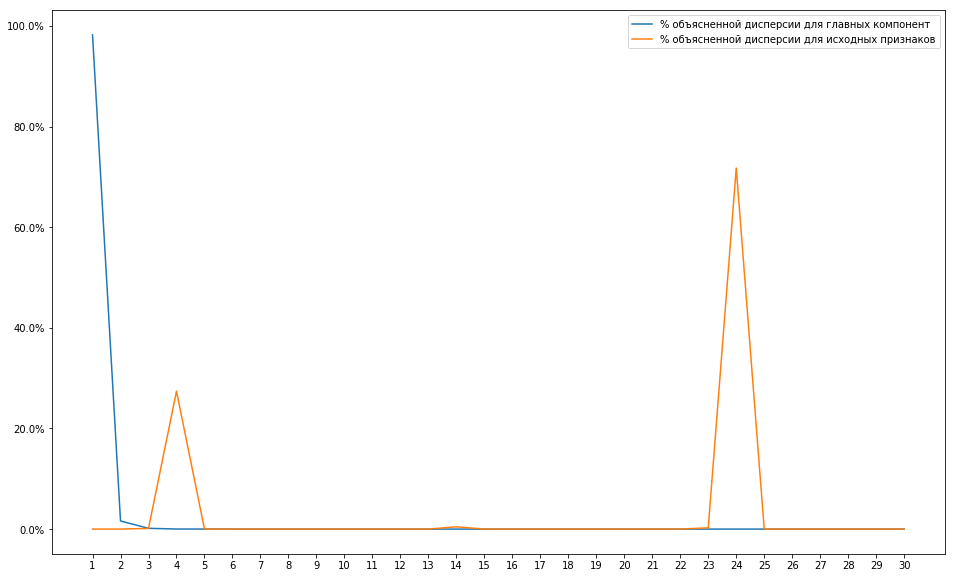

In [23]:
xx = range(1, 31)
axes().yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:.1%}'))
xticks(xx)
plot(xx, pca.explained_variance_ratio_, label='% объясненной дисперсии для главных компонент')
plot(xx, explained_variance_ratio, label='% объясненной дисперсии для исходных признаков')
legend()
None

# Классификация по исходным данным

## Разбиение выборки на тестовую и тренировочную

In [6]:
X_train, X_test, y_train, y_test = train_test_split(breast_cancer_data, breast_cancer_target, test_size=0.1, random_state=42)

## Обучение классификатора при произвольном k

In [25]:
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)
print(f'Точность: {knn_clf.score(X_test, y_test):.2%}')

Точность: 96.49%


### Кроссвалидация на 10 фолдов

In [26]:
cv_scores = cross_val_score(knn_clf, X_train, y_train, scoring='accuracy', cv=10)
print('Точности для различных фолдов: ', [f'{score:.1%}' for score in cv_scores])
print('Дисперсия: {:}'.format(var(cv_scores)))

Точности для различных фолдов:  ['92.3%', '94.2%', '98.1%', '90.4%', '90.4%', '94.1%', '94.1%', '92.0%', '90.0%', '88.0%']
Дисперсия: 0.0007487741856227342


### Графики зависимости точности от числа k и n

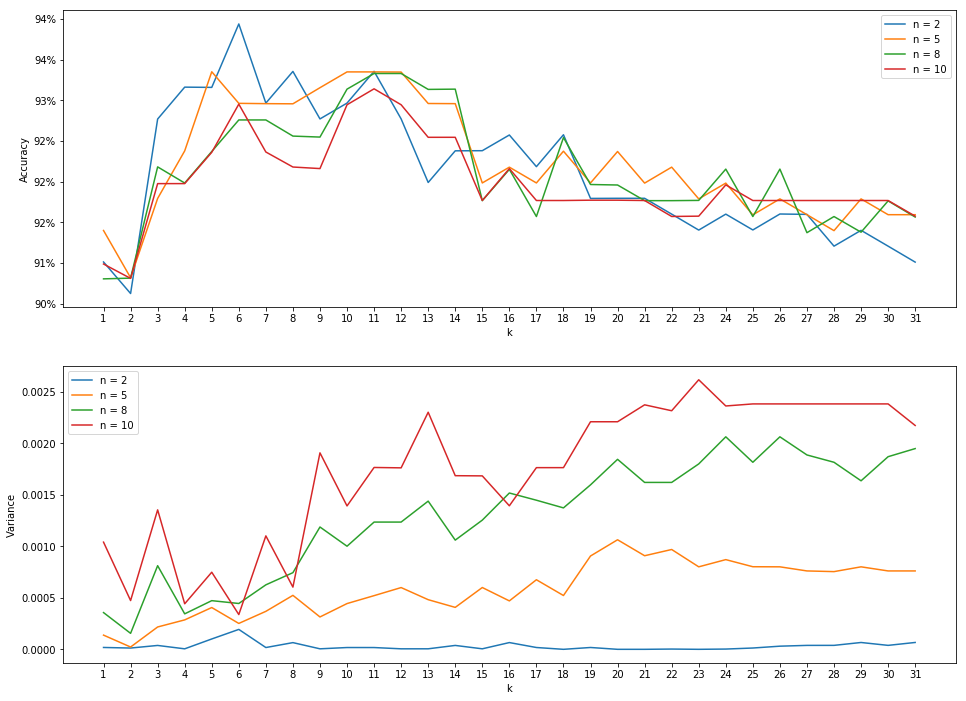

In [70]:
figsize(16, 12)
fig, (axes1, axes2) = subplots(nrows=2, ncols=1)
xx = range(1, 32)

for axes_i in (axes1, axes2):
    axes_i.set_xticks(xx)
    axes_i.set_xlabel('k')

axes1.set_ylabel('Accuracy')
axes2.set_ylabel('Variance')

axes1.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:.0%}'))

for n in (2, 5, 8, 10):
    scores_variances = []
    scores_means = []
    for k in xx:
        cv_scores = cross_val_score(KNeighborsClassifier(n_neighbors=k), X_train, y_train, scoring='accuracy', cv=n)
        scores_variance = var(cv_scores)
        scores_mean = mean(cv_scores)
        scores_variances.append(scores_variance)
        scores_means.append(scores_mean)
    if n == 5:
        scores_mean_source = scores_means
    axes1.plot(xx, scores_means, label=f'n = {n}')
    axes2.plot(xx, scores_variances, label=f'n = {n}')

axes1.legend()
axes2.legend()

None

#### Вывод о сравнительном качестве предсказаний

По графикам видно, что чем большее количество фолдов изпользуется для кросс-валидации, тем больше разбров в значениях точности для различных фолдов

#### Наиболее приемлемый диапазон значений k

Наибольшее значение точности практически при любом количестве фолдов при кросс-валидации достигается при k = 11

# Классификация по данным, спроецированным на главные компоненты

In [58]:
ks = range(1, 32)
n_components = (2, 3, 5, 7, 10, 15, 20)

pipe = Pipeline([
    ('pca', PCA()),   # n_components
    ('knn', KNeighborsClassifier())  # n_neighbors
])

params = {
    'pca__n_components': n_components, 
    'knn__n_neighbors': ks, 
}

grid_cv = GridSearchCV(pipe, params, scoring='accuracy', cv=3, return_train_score=False)
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'pca__n_components': (2, 3, 5, 7, 10, 15, 20), 'knn__n_neighbors': range(1, 32)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='accuracy', verbose=0)

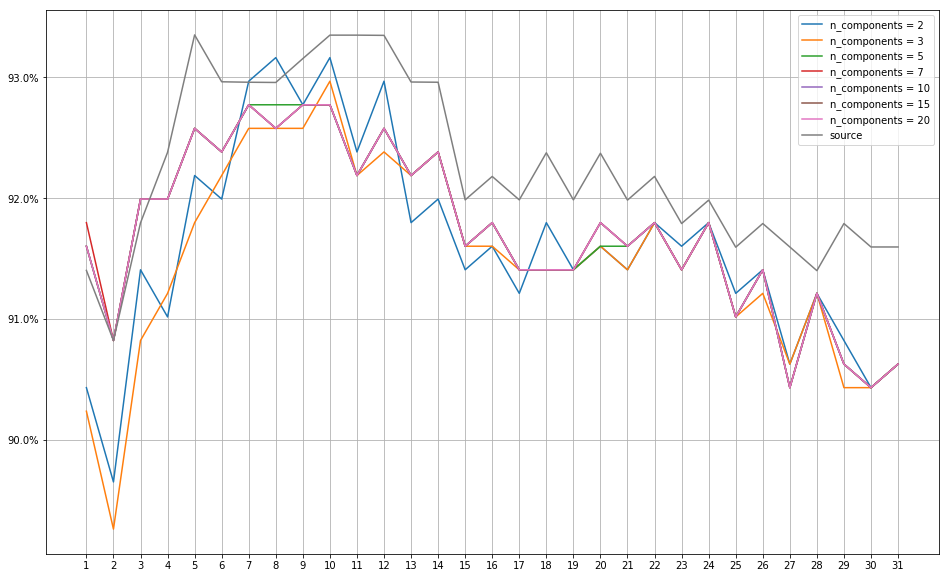

In [75]:
mean_scores = array(grid_cv.cv_results_['mean_test_score']).reshape(len(ks), len(n_components))

figsize(16, 10)
axes().yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:.1%}'))
xticks(ks)
grid(True)

for i, k in enumerate(n_components):
    plot(ks, mean_scores[: , i], label=f'n_components = {k}')
plot(ks, scores_mean_source, label='source')
legend()
None

Для выбранного количества фолдов кросс-валидации (5) и выбранного набора количества главных компонент (2, 3, 5, 7, 10, 15, 20), качество классификации на исходных данных выше практически на всем диапазоне перебираемых значений количества соседей

Из графика видно, что изменение количества главных компонент незначительно влияет на качество кластеризации и находится в достаточно близких пределах друг от друга